In [1]:
import chess
from model import GPTConfig, GPT
from tokenizers import Tokenizer
import torch
import os
import numpy as np
import chess.pgn
import io

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = 'cuda'

In [3]:

ckpt_path = os.path.join("out", 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
checkpoint_model_args = checkpoint['model_args']
# force these config attributes to be equal otherwise we can't even resume training
# the rest of the attributes (e.g. dropout) can stay as desired from command line
# create the model
gptconf = GPTConfig(**checkpoint_model_args)
model = GPT(gptconf)
state_dict = checkpoint['model']
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
iter_num = checkpoint['iter_num']
best_val_loss = checkpoint['best_val_loss']
model.to(device)

number of parameters: 102.85M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(23296, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=23296, bias=False)
)

In [4]:
tokenizer = Tokenizer.from_file("/data/evan/CS285_Final_Project/model/tokenizer.model")

In [5]:


def get_engine_move(seq, board, tokenizer):
    ids_list = tokenizer.encode(seq).ids
    ids = torch.stack([torch.IntTensor(ids_list)]).to(device)
    out_ids = model.generate_legal(ids, 50, board, tokenizer, top_k=20)
    line = tokenizer.decode(out_ids.to('cpu').numpy()[0]).split(" ")
    move = line[0]
    return move, line

def get_seq(mainline_moves):
    board = chess.Board()
    seq = ""
    turns = ['<b>', '<w>']

    for move in mainline_moves:
        bool_turn = board.turn
        turn = turns[int(bool_turn)]
        lan = board.lan(move)
        seq += turn + lan
        board.push(move)
    return seq + turns[int(~bool_turn)]

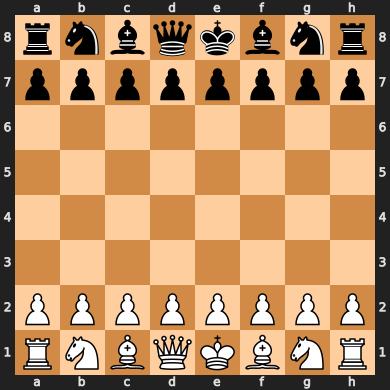

In [73]:
# starting_pgn = ""
# pgn = io.StringIO(starting_pgn)
# game = chess.pgn.read_game()
game = chess.pgn.Game()
board = game.board()
for move in game.mainline_moves():
    board.push(move)
board

In [74]:
san = "e5"
board.push_san(san)
display(board)
seq = get_seq(board.move_stack)
# print(seq)
ids_list = tokenizer.encode(seq).ids
ids = torch.stack([torch.IntTensor(ids_list)]).to(device)
model.generate_legal(ids, 1000, board, tokenizer, top_k=1)



['Ng1-f3',
 'Ng8-f6',
 'c2-c4',
 'e7-e6',
 'Nb1-c3',
 'd7-d5',
 'd2-d4',
 'Bf8-e7',
 'Bc1-g5',
 'O-O',
 'e2-e3',
 'h7-h6',
 'Bg5-h4',
 'b7-b6',
 'c4xd5',
 'Nf6xd5',
 'Bh4xe7',
 'Qd8xe7',
 'Nc3xd5',
 'e6xd5',
 'Bf1-d3',
 'Bc8-e6',
 'O-O',
 'c7-c5',
 'd4xc5',
 'b6xc5',
 'Ra1-c1',
 'Nb8-d7',
 'Bd3-b1',
 'Ra8-b8',
 'b2-b3',
 'Rf8-c8',
 'Qd1-d3',
 'Nd7-f6',
 'Rf1-d1',
 'c5-c4',
 'b3xc4',
 'd5xc4',
 'Qd3-c2',
 'c4-c3',
 'Nf3-d4',
 'Rb8-b2',
 'Qc2-d3',
 'Qe7-b4',
 'Nd4xe6',
 'f7xe6',
 'Bb1-c2',
 'Rb2xa2',
 'Qd3-g6',
 'Qb4-c5',
 'Bc2-b3',
 'Ra2-d2',
 'Bb3xe6+',
 'Kg8-h8',
 'Be6xc8',
 'Qc5xc8',
 'h2-h3',
 'Rd2xd1+',
 'Rc1xd1',
 'c3-c2',
 'Rd1-c1',
 'Qc8-c3',
 'Rc1xc2',
 'Qc3-a1+',
 'Kg1-h2',
 'Qa1-e5+',
 'g2-g3',
 'Qe5-e8',
 'Qg6xe8+',
 'Nf6xe8',
 'Rc2-c8',
 'Kh8-h7',
 'Rc8xe8',
 'a7-a5',
 'Re8-a8',
 'a5-a4',
 'Ra8xa4',
 'Kh7-g6',
 'Ra4-f4',
 'Kg6-h7',
 'g3-g4',
 'Kh7-g6',
 'Kh2-g3',
 'Kg6-h7',
 'h3-h4',
 'Kh7-g6',
 'h4-h5+',
 'Kg6-h7',
 'Rf4-f5',
 'Kh7-g8',
 'f2-f4',
 'Kg8-h7',
 'g4-g5',
 'Kh7

In [75]:
board.move_stack

[Move.from_uci('g1f3'),
 Move.from_uci('g8f6'),
 Move.from_uci('c2c4'),
 Move.from_uci('e7e6'),
 Move.from_uci('b1c3'),
 Move.from_uci('d7d5'),
 Move.from_uci('d2d4'),
 Move.from_uci('f8e7'),
 Move.from_uci('c1g5'),
 Move.from_uci('e8g8'),
 Move.from_uci('e2e3'),
 Move.from_uci('h7h6'),
 Move.from_uci('g5h4'),
 Move.from_uci('b7b6'),
 Move.from_uci('c4d5'),
 Move.from_uci('f6d5'),
 Move.from_uci('h4e7'),
 Move.from_uci('d8e7'),
 Move.from_uci('c3d5'),
 Move.from_uci('e6d5'),
 Move.from_uci('f1d3'),
 Move.from_uci('c8e6'),
 Move.from_uci('e1g1'),
 Move.from_uci('c7c5'),
 Move.from_uci('d4c5'),
 Move.from_uci('b6c5'),
 Move.from_uci('a1c1'),
 Move.from_uci('b8d7'),
 Move.from_uci('d3b1'),
 Move.from_uci('a8b8'),
 Move.from_uci('b2b3'),
 Move.from_uci('f8c8'),
 Move.from_uci('d1d3'),
 Move.from_uci('d7f6'),
 Move.from_uci('f1d1'),
 Move.from_uci('c5c4'),
 Move.from_uci('b3c4'),
 Move.from_uci('d5c4'),
 Move.from_uci('d3c2'),
 Move.from_uci('c4c3'),
 Move.from_uci('f3d4'),
 Move.from_uci('

In [76]:
game = chess.pgn.Game()
node = game
for move in board.move_stack:
    node = node.add_main_variation(move)


In [77]:
print(game)

[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. Nf3 Nf6 2. c4 e6 3. Nc3 d5 4. d4 Be7 5. Bg5 O-O 6. e3 h6 7. Bh4 b6 8. cxd5 Nxd5 9. Bxe7 Qxe7 10. Nxd5 exd5 11. Bd3 Be6 12. O-O c5 13. dxc5 bxc5 14. Rc1 Nd7 15. Bb1 Rab8 16. b3 Rfc8 17. Qd3 Nf6 18. Rfd1 c4 19. bxc4 dxc4 20. Qc2 c3 21. Nd4 Rb2 22. Qd3 Qb4 23. Nxe6 fxe6 24. Bc2 Rxa2 25. Qg6 Qc5 26. Bb3 Rd2 27. Bxe6+ Kh8 28. Bxc8 Qxc8 29. h3 Rxd1+ 30. Rxd1 c2 31. Rc1 Qc3 32. Rxc2 Qa1+ 33. Kh2 Qe5+ 34. g3 Qe8 35. Qxe8+ Nxe8 36. Rc8 Kh7 37. Rxe8 a5 38. Ra8 a4 39. Rxa4 Kg6 40. Rf4 Kh7 41. g4 Kg6 42. Kg3 Kh7 43. h4 Kg6 44. h5+ Kh7 45. Rf5 Kg8 46. f4 Kh7 47. g5 Kg8 48. g6 Kh8 49. Rf8# *


In [44]:
game.mainline_moves()

AssertionError: san() and lan() expect move to be legal or null, but got c3e3 in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1